### Import libs, global variables and pickled files

In [1]:
import pickle, os, cv2, random, tqdm, json
from random import choice as r_ch
import numpy as np
import pandas as pd

from os.path import join as join_path
from os.path import sep as os_sep
from os.path import exists as path_exists

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

from global_names import A2D2_PATH


with open("bm_ds.pkl", "rb") as f:
    bm_ds = pickle.load(f)
    
# Load files
with open(join_path(A2D2_PATH, "camera_lidar_semantic", "class_list.json"), "rb") as f:
     class_list= json.load(f)

### Define functions for getting paths from ids

In [2]:
ss_p = join_path(A2D2_PATH, "camera_lidar_semantic")

sens_ext = {
    "camera": ".png",
    "label": ".png",
    "lidar": ".npz"
}

rel_ = lambda __p: join_path(*__p.split(os_sep)[__p.split(os_sep).index('camera_lidar_semantic'):])
abs_ = lambda __p: join_path(A2D2_PATH, __p)

def sensor_p(_id, s_type):
    if s_type not in sens_ext.keys(): raise ValueError("Wrong sensor type: s_type")
    d,t,s = _id.split("_")
    _p = "_".join([d, s_type, s, t]) + sens_ext[s_type]
    _p = join_path(ss_p, f"{d[:8]}_{d[8:]}", s_type, f"cam_{sa_(s)}", _p)
    return rel_(_p)

def sa_(x):
    als = ["center", "left", "right"]
    for o in als:
        if o in x:
            return x.replace(o, "_" + o)
    raise ValueError(f"Bad index contains wrong sensor align: {x}")

### Create dataset from sparced ids

In [3]:
# It's important to reduce number of images
sparced_ids = [val for i, val in enumerate(bm_ds["train_ids"]) if i % 10 == 0]
x_train_dir = np.array([abs_(sensor_p(p, "camera")) for p in sparced_ids])
y_train_dir = np.array([abs_(sensor_p(p, "label")) for p in sparced_ids])

# It's important to reduce number of images
sparced_val_ids = [val for i, val in enumerate(bm_ds["val_ids"]) if i % 10 == 0]
val_images_paths = np.array([abs_(sensor_p(p, "camera")) for p in sparced_val_ids])
val_labels_paths = np.array([abs_(sensor_p(p, "label")) for p in sparced_val_ids])

In [4]:
class_names = list(class_list.values())
class_rgb_values = [[int(i[1:3], 16), int(i[3:5], 16), int(i[5:7], 16)] for i in class_list.keys()]

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names # all classes

# Get RGB values of required classes
select_class_indices = [class_names.index(cls) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [5]:
class A2D2_Dataset(torch.utils.data.Dataset):

    """Audi Autonomous Driving Dataset. 
       Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_list, 
            masks_list, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = images_list
        self.mask_paths = masks_list

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

### Create model

In [6]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [7]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Define training

In [19]:
# Get train and val dataset instances
train_dataset = A2D2_Dataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = A2D2_Dataset(
    val_images_paths, val_labels_paths, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

In [20]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [21]:
# load best saved model checkpoint from previous commit (if present)
if os.path.exists('best_baseline_model.pth'):
    model = torch.load('best_baseline_model.pth', map_location=DEVICE)

In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [64]:
# Set num of epochs
EPOCHS = 5

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

### Run training loop

In [25]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_baseline_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 283/283 [59:59<00:00, 12.72s/it, dice_loss - 0.4065, iou_score - 0.4482]
Model saved!

Epoch: 1
valid: 100%|██████████| 283/283 [57:58<00:00, 12.29s/it, dice_loss - 0.3594, iou_score - 0.4877]
Model saved!

Epoch: 2
valid: 100%|██████████| 283/283 [58:41<00:00, 12.44s/it, dice_loss - 0.3166, iou_score - 0.5333]
Model saved!

Epoch: 3
valid: 100%|██████████| 283/283 [58:07<00:00, 12.32s/it, dice_loss - 0.3736, iou_score - 0.479] 

Epoch: 4
valid: 100%|██████████| 283/283 [58:10<00:00, 12.34s/it, dice_loss - 0.214, iou_score - 0.6901] 
Model saved!
CPU times: user 1d 53min 57s, sys: 5h 57min 37s, total: 1d 6h 51min 34s
Wall time: 21h 25min 8s


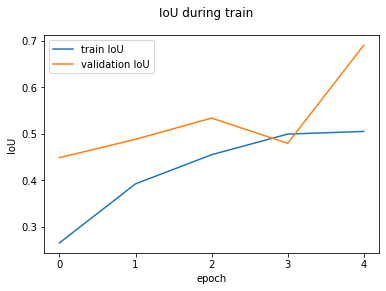

In [62]:
fig, ax = plt.subplots()

score_train = [i["iou_score"] for i in train_logs_list]
score_valid = [i["iou_score"] for i in valid_logs_list]

ax.plot(score_train, label="train IoU")
ax.plot(score_valid, label="validation IoU")
ax.set_xticks([i for i in range(5)])

plt.suptitle("IoU during train")
plt.xlabel("epoch")
plt.ylabel("IoU")

plt.legend()
plt.show()

### Check IoU on the test benchmark

In [72]:
test_ids = bm_ds["test_ids"]
x_test_dir = np.array([abs_(sensor_p(p, "camera")) for p in test_ids])
y_test_dir = np.array([abs_(sensor_p(p, "label")) for p in test_ids])

In [120]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = A2D2_Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
x_tensor.shape

In [ ]:
image, gt_mask = test_dataset[0]
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

pred_mask = model(x_tensor)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()

In [ ]:
gt_mask.shape

In [ ]:
pred_mask.shape